<a href="https://colab.research.google.com/github/HninPannPhyu/VRPTW-Column-Generation/blob/master/Copy_of_deepmab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.preprocessing import  MinMaxScaler
from collections import OrderedDict
from torch.autograd import Variable
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [52]:

def running_mean(data,window=50):
    c = data.shape[0] - window
    smoothened = np.zeros(c)
    conv = np.ones(window)
    for i in range(c):
        smoothened[i] = (data[i:i+window] @ conv)/window
    return smoothened

In [53]:
def one_hot_encode(pos, dim):
  vec = np.zeros(dim)
  vec[pos] = 1
  return vec

In [54]:
def softmax(data, tau=1.2):
  softm = np.exp(data/tau) / np.sum(np.exp(data/tau))
  return softm

In [ ]:
#directory=r'sample_data/testing_data.csv'

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
directory=r'drive/MyDrive/testing_data.csv'

In [ ]:
df= pd.read_csv(directory, header=None, skiprows=1)
print(df.head())
state=df.sample()
print(state.iloc[0])
print("state:",state[:-1])

a=pd.to_numeric(state.iloc[0], downcast="integer")
print(a)
print(len(df))


In [57]:
class Env(object):

  def __init__(self, configs):
    self.configs = configs # [eMBB, URLLC, mMTC, EcoSlice]
    self._update_state()

    self.slice_instance=[3,4,2,2]#embb, urllc, mmtc, ecoslice fixed delay
   
    self.power_traffic = 200 #load depended power
    self.power_static = 30 #static power of slice instance to run their corresponding functions
    self.power_basic = 20 # base power of 
    self.psi = [4,3,2,1]  # eMBB, URLLC, mMTC, EcoSlice, power impact factor of slice instances , the larger value means more power consumption 
    self.delay_max=1 #delay range max to generate user demand 
    self.delay_min=4 #delay range min to generate user demand 
    self.num_user=10
    self.num_slice=len(self.slice_instance)-1
    np.random.seed(0) 
    self.user_de = np.random.randint(self.delay_max,self.delay_min,size=(self.num_user,self.num_slice))
    
    

  def _update_state(self):
    self.df= pd.read_csv(directory,header=None, skiprows=1)
    self.df=self.df.fillna(0)
    #df=df.apply(pd.to_numeric)
    self.state=self.df.sample()
    self.state_time=self.state[0]

  def get_state(self):
    return self.state_time.index.values #get only the SADI

  def get_entire_state(self): #get the reward impact factor 
    return self.state

  def get_user_demand(self):
     return self.user_de

  
  def _get_reward(self, config):
    state_ = self.get_entire_state()
    state=pd.to_numeric(state_.iloc[0])
    config_= self.configs[config]
    user_demand=self.get_user_demand()
    Energy = np.full(len(config_)+1,0)
    QoS = np.full(len(config_),0)
    traffic_portion = np.full(len(config_),0)
    rewards = np.full(len(config_),0)
    for i in range(0,len(config_)):
      if config_[i] == 0:
        Energy[i] = 0 
        net_user_trafficload = state[4]
        #b=pd.to_numeric(a.iloc[0], downcast="integer")
        traffic_portion[i]= int(state[i+1])/ int(net_user_trafficload) if int(net_user_trafficload) !=0 else 0
        
        Energy[-1] =+ traffic_portion[i]*self.psi[-1]* self.power_traffic + self.psi[-1] * self.power_static 
        for x in range (0, len(user_demand)):

          if user_demand[x][i] <= self.slice_instance[-1]: #ecoslice
            QoS[i]=+1
          else:
            QoS[i] =+0.5
      else:
        net_user_trafficload = state[4]
        traffic_portion[i]= int(state[i+1])/ int(net_user_trafficload) if int(net_user_trafficload) !=0 else 0
        
        Energy[i]=+ traffic_portion[i]*self.psi[i]* self.power_traffic + self.psi[i] * self.power_static 

        for x in range (0, len(user_demand)):

          if user_demand[x][i] <= self.slice_instance[i]:
            QoS[i]=+1
          else:
            QoS[i] =+0

        rewards[i] = 1/Energy[i] + QoS [i]
      
    return sum(rewards), sum(Energy)+self.power_basic , sum(QoS)  #QoS should be average of all slice or ? 

  def choose_config(self, config):
    reward,overall_Energy, overall_qos= self._get_reward(config)
    self._update_state()
    return reward, overall_Energy, overall_qos



In [26]:
E=[1,2,4,5]
print(sum(E))

12


In [9]:
#neural network to predict the reward distributions for each state 
n_state = 1434
n_configs = 6

model = nn.Sequential(OrderedDict([
          ('Linear1', nn.Linear(n_state,100)),
          ('relu1', nn.ReLU()),
          ('Linear2', nn.Linear(100, n_configs)),
          ('relu2', nn.ReLU())
        ]))

In [58]:

#neural network to predict the reward distributions for each state 
class Net(nn.Module):
  def __init__(self,input_shape,output_shape):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_shape,100)
    #self.fc2 = nn.Linear(100,100)
    self.fc3 = nn.Linear(100,output_shape)
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    #x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    return x

In [59]:
def train_network(environ, net, epochs=8000, lr=1e-2, state_length=1434, device=torch.device):
  optimizer = optim.Adam(net.parameters(), lr=lr)
  criterion = nn.MSELoss()
  rewards = []
  losses = []
  overall_energy_=[]
  overall_qos_=[]
  for e in range(1, epochs + 1):
    state = torch.Tensor(one_hot_encode(int(environ.get_state()), dim=state_length))
    #state=torch.flatten(state)
    #state=state.view(state_length,1,1)
    rewards_pred = net(state)
    action_probas = softmax(rewards_pred.data.numpy().copy())
    print(action_probas.size)
    config = np.random.choice(n_configs, p=action_probas)
    
    #config=np.max(action_probas)
    reward , overall_energy, overall_qos= environ.choose_config(config)
    rewards.append(reward)
    overall_energy_.append(overall_energy)
    overall_qos_.append(overall_qos)

    true_rewards = rewards_pred.data.numpy().copy()
    true_rewards[config] = reward 

    loss = criterion(rewards_pred, torch.Tensor(true_rewards))
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'Epoch {e+1} \t\t Training Loss: {loss} \t\t Rewards: {reward}')

  return (np.array(losses), np.array(rewards), np.array(overall_energy_), np.array(overall_qos_))



In [60]:
env = Env(configs= [[0,1,1], [0,1,0],[0,1,1],[1,1,1],[1,0,0],[0,0,1] ])
print(f"CURRENT STATE : {env.get_state()}")

CURRENT STATE : [314]


In [61]:
n_state = 1434
n_configs = 6
model=Net(n_state,n_configs)

In [62]:
losses, rewards, overall_energy_, overall_qos_ = train_network(env, model)

Streaming output truncated to the last 5000 lines.
6
Epoch 5502 		 Training Loss: 4.301213039070717e-07 		 Rewards: 3
6
Epoch 5503 		 Training Loss: 1.9134380636387505e-05 		 Rewards: 3
6
Epoch 5504 		 Training Loss: 0.0024402167182415724 		 Rewards: 3
6
Epoch 5505 		 Training Loss: 0.0009277322678826749 		 Rewards: 1
6
Epoch 5506 		 Training Loss: 0.002299821237102151 		 Rewards: 2
6
Epoch 5507 		 Training Loss: 0.0007008502725511789 		 Rewards: 3
6
Epoch 5508 		 Training Loss: 0.00012973813863936812 		 Rewards: 2
6
Epoch 5509 		 Training Loss: 0.001792433555237949 		 Rewards: 1
6
Epoch 5510 		 Training Loss: 3.064908742089756e-05 		 Rewards: 1
6
Epoch 5511 		 Training Loss: 0.0015721431700512767 		 Rewards: 1
6
Epoch 5512 		 Training Loss: 0.0006253669271245599 		 Rewards: 2
6
Epoch 5513 		 Training Loss: 1.183954054795322e-06 		 Rewards: 3
6
Epoch 5514 		 Training Loss: 4.824009920412209e-07 		 Rewards: 1
6
Epoch 5515 		 Training Loss: 0.0013642181875184178 		 Rewards: 3
6
Epoch 551

In [ ]:
def main():
   
   n_configs = 6
   env = Env(configs= [[0,1,1], [0,1,0],[0,1,1],[1,1,1],[1,0,0],[0,0,1] ])
   state = torch.Tensor(one_hot_encode(int(env.get_state()), dim=1434))
   DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
   net=model().to(DEVICE)
   losses, rewards=train_network(env,net, device=DEVICE)

In [ ]:
if __name__ == "__main__":
    main()

In [63]:
print(losses[-1])

0.00037774068186990917


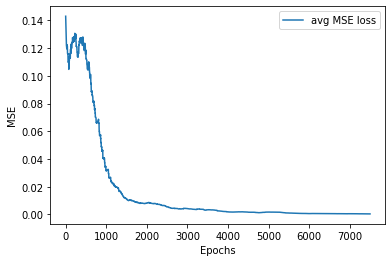

In [64]:
plt.plot(running_mean(losses, window=500), label="avg MSE loss")
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

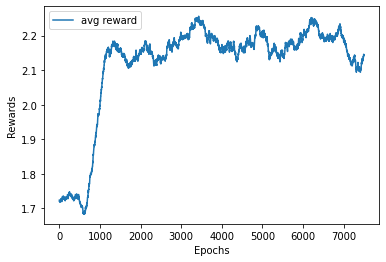

In [65]:
plt.plot(running_mean(rewards, window=500), label="avg reward")
plt.xlabel('Epochs')
plt.ylabel('Rewards')
plt.legend()

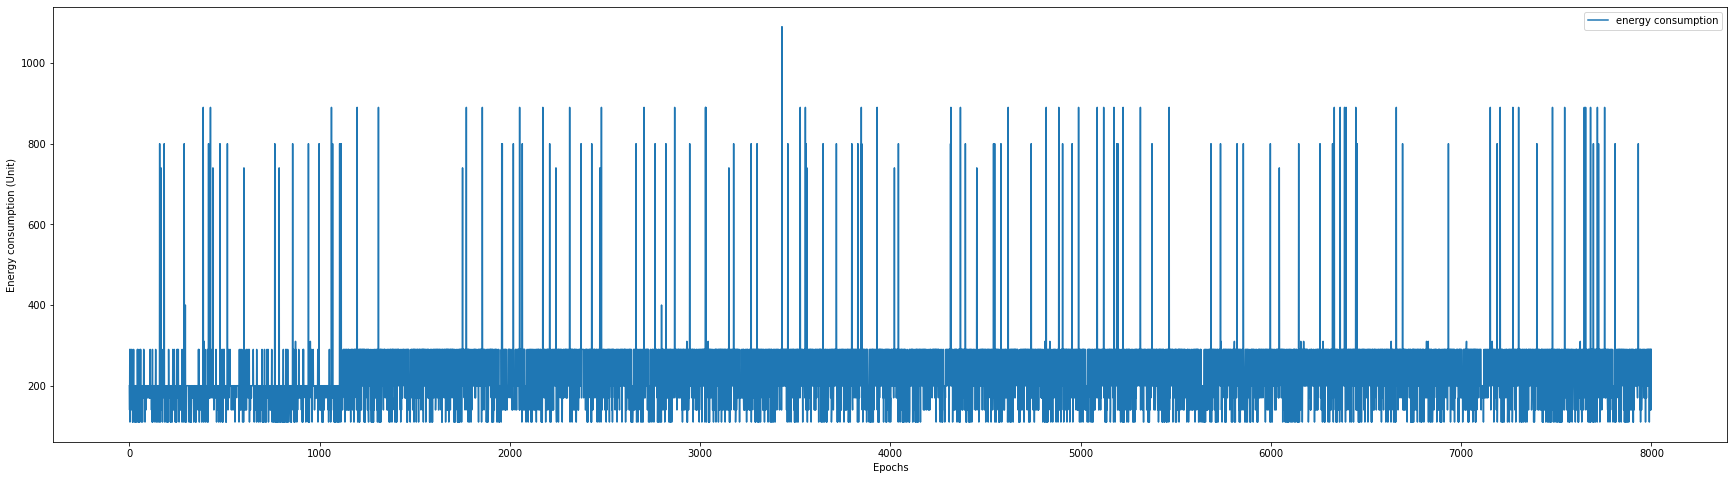

In [66]:
plt.figure(figsize=(30,8))
plt.plot(overall_energy_, label="energy consumption")
plt.xlabel('Epochs')
plt.ylabel('Energy consumption (Unit)')
plt.legend()
#to show with CDF?

In [75]:
#save the overall energy consumption as csv file at google drive
import time
directory_save=r'drive/MyDrive/DeepCareResults/overall_energy_{}.csv'.format(int(time.time()))

pd.DataFrame(overall_energy_).to_csv(directory_save)

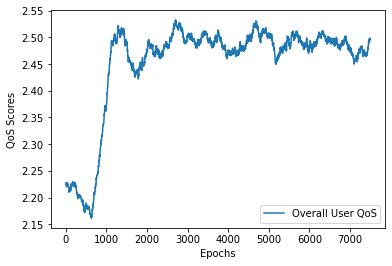

In [72]:
#plt.figure(figsize=(30,8))
plt.plot(running_mean(overall_qos_, window=500), label="Overall User QoS")
plt.xlabel('Epochs')
plt.ylabel('QoS Scores')
plt.legend()

In [67]:
selected_configs=[]
for i in range(0,1434):
  state = torch.Tensor(one_hot_encode(i, dim=1434))
  preds = model(state)
  arms_prob=softmax(preds.data.numpy().copy())
  selected_config=np.random.choice(6, p=arms_prob)
  selected_configs.append(selected_config)
print(selected_configs)

[2, 3, 5, 3, 3, 3, 1, 3, 3, 2, 3, 0, 5, 0, 2, 3, 3, 2, 0, 4, 5, 3, 3, 2, 1, 3, 3, 3, 3, 2, 1, 2, 3, 3, 3, 3, 3, 2, 0, 4, 5, 0, 3, 3, 3, 2, 3, 1, 3, 5, 3, 3, 3, 3, 0, 3, 2, 2, 2, 5, 0, 3, 4, 2, 0, 3, 5, 3, 3, 3, 2, 5, 4, 2, 0, 0, 0, 0, 2, 5, 3, 0, 4, 4, 3, 2, 0, 3, 2, 5, 3, 1, 1, 3, 0, 3, 3, 0, 4, 1, 3, 0, 4, 5, 0, 4, 0, 3, 3, 5, 0, 0, 0, 2, 2, 0, 0, 3, 5, 0, 0, 0, 3, 3, 0, 0, 3, 1, 2, 5, 3, 3, 3, 2, 4, 2, 2, 0, 3, 1, 0, 3, 3, 0, 2, 0, 0, 4, 3, 1, 3, 0, 2, 3, 3, 3, 3, 2, 0, 2, 3, 2, 3, 3, 0, 3, 3, 2, 3, 3, 3, 1, 3, 3, 0, 0, 5, 4, 2, 3, 4, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 3, 2, 0, 0, 3, 0, 3, 2, 2, 0, 2, 3, 2, 0, 0, 3, 3, 3, 1, 1, 2, 5, 0, 2, 0, 3, 3, 2, 3, 4, 3, 3, 1, 5, 2, 3, 0, 2, 0, 0, 0, 2, 2, 3, 3, 2, 5, 0, 0, 3, 4, 3, 0, 0, 2, 3, 1, 2, 3, 3, 5, 5, 0, 2, 2, 2, 2, 3, 3, 3, 2, 3, 4, 0, 3, 2, 3, 3, 1, 0, 2, 0, 3, 3, 5, 3, 3, 3, 1, 3, 2, 3, 2, 3, 1, 5, 1, 2, 2, 2, 3, 3, 3, 4, 5, 3, 3, 3, 0, 0, 0, 3, 4, 3, 4, 3, 0, 3, 1, 3, 0, 5, 2, 4, 5, 5, 3, 3, 2, 2, 

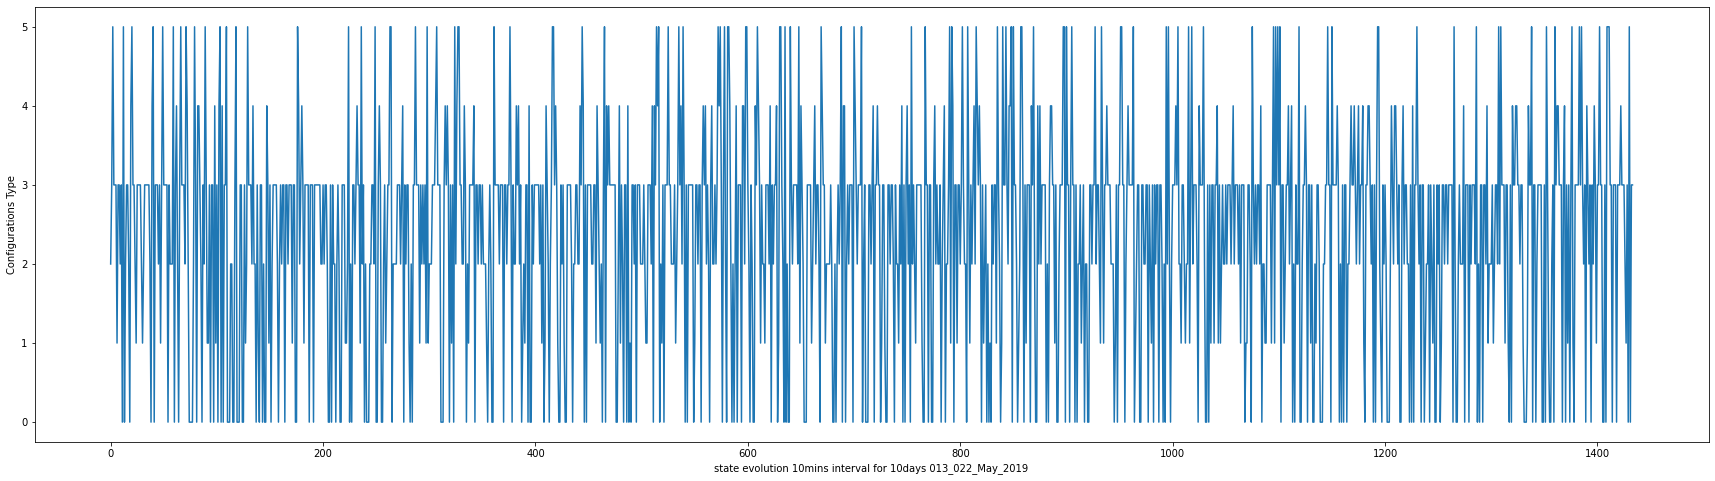

In [68]:
plt.figure(figsize=(30,8))
plt.plot(selected_configs)
plt.xlabel('state evolution 10mins interval for 10days 013_022_May_2019')
plt.ylabel('Configurations Type')
plt.show()

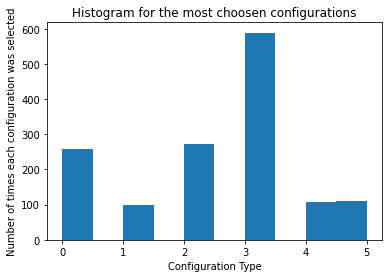

In [69]:
plt.hist(selected_configs)
plt.title('Histogram for the most choosen configurations')
plt.xlabel('Configuration Type')
plt.ylabel('Number of times each configuration was selected')
plt.show()

In [ ]:
import pandas as pd

directory=r'sample_data/testing_data.csv'

df=pd.read_csv(directory, header=None)

a=df.sample()
b=pd.to_numeric(a.iloc[0])
print(b)
print(b[1])

print(b[4])
c= b[1]/b[4]
print (c)






0    8.280000e+02
1    7.913559e+07
2    1.039496e+07
3    3.065569e+08
4    3.960875e+08
Name: 829, dtype: float64
79135588.16
396087489.6
0.1997932028600986


In [ ]:
df= pd.read_csv(directory, header=None, skiprows=1)
print(df.head())
state=df.sample()
print(state.iloc[0])
print(state)

a=pd.to_numeric(state.iloc[0], downcast="integer")
print(a)


In [ ]:
class Environment(object):

  def __init__(self, configs):
    self.configs = [[0,1,1,1], [0,1,0,1] ] # [eMBB, URLLC, mMTC, EcoSlice]
    self._update_state()
    self.df= pd.read_csv(directory)
    self.slice[0]=3 #embb delay
    self.slice[1]=4 #urllc delay
    self.slice[2]=2 #mmtc delay
    self.slice[3]=2 #ecoslice
    self.power_traffic = 200  #load_dependent traffic
    self.power_static = 30  
    self.power_basic = 20
    self.psi = [2,3,1,1]

  def _update_state(self):
    self.estate=self.df.sample()
    self.state = self.estate['Date']

  def get_state(self):
    return self.state 

  def user_demand(self):
    self.user_de = [[[2,100],[3,300],[2,200]], #user index, slice type, service type
                    [[4,300],[4,500],[2,300]]]
    self.user_traffic_load= np.full(len(self.user_de[0]),0)
    self.net_user_trafficload=[]
    for x in range(0, len(self.user_de)):
      for i in range(0, len(self.user_de[0])):
        self.user_traffic_load[i]=+self.user_de[x][i][1]
        self.net_user_trafficload= +self.user_traffic_load[i]
    

  def _get_reward(self, config):
    state = self.get_state()
    config_= self.configs[config]
    Energy = np.full(len(config_),0)
    QoS = np.full(len(config_),0)
    traffic_portion = np.full(len(config_),0)
    rewards = np.full(len(config_),0)
    for i in range(0,len(config_)):
      if config_[i] == 0:
        Energy[i] = 0
        for x in range (0, len(user_de)):

          if user_de[x][i][0] <= self.slice[3]:
            QoS[i]=+1
          else:
            QoS[i] =+0.5
      else:
        traffic_portion[i]= self.user_traffic_load[i]/ self.net_user_trafficload
        Energy[i]= traffic_portion[i]*self.psi[i]* self.power_traffic + self.psi[i] * self.power_static 

        for x in range (0, len(user_de)):

          if user_de[x][i][0] <= self.slice[i]:
            QoS[i]=+1
          else:
            QoS[i] =+0

        rewards[i] = 1/Energy[i] + QoS [i]

    return sum(rewards)

  def choose_arm(self, arm):
    reward = self._get_reward(arm)
    self._update_state()
    return reward

In [ ]:
config=[1,2,3]
for i in range(0,len(config)):
  print(i)

0
1
2


In [ ]:
user_de = [[[2],[3],[2]],
                    [[4],[4],[2]]]

print(user_de[0][1][0]) #user count, slice type, service type
print(len(user_de))
print(len(user_de[0]))

3
2
3


In [ ]:
import pandas as pd
import numpy as np
directory=r'sample_data/testing_data_MAB.csv'

df= pd.read_csv(directory, header=None)


dff=df.sample()
print(dff)
sum=dff.iloc[:, 1:4].sum(axis=1)
print(sum)



                     0            1            2            3  4
1365  2019-05-22 10:20  16426747.69  3681495.167  7003945.626  0
1365    16426747.693681495.1677003945.626
dtype: object


In [ ]:
print(env.reward_probas)

[[0.81246612 0.64522327 0.35781976 0.91953499 0.15363208]
 [0.26711051 0.03066976 0.36206882 0.82395886 0.86792436]
 [0.72775729 0.60831241 0.26602619 0.47589415 0.53978909]
 [0.10674921 0.32590551 0.6885265  0.37942169 0.21306574]
 [0.95358345 0.43783031 0.21295601 0.86404765 0.26097755]]


In [ ]:
state = env.get_state()
print(state)

1


In [ ]:
env.choose_arm(2)

2

In [ ]:
print(env.get_state())

2


In [ ]:
n_config = 10
n_actions = 10
model = nn.Sequential(
    nn.Linear(n_config, 100),
    nn.ReLU(),
    nn.Linear(100, n_actions),
    nn.ReLU()
)

In [ ]:
print(model)

Sequential(
  (0): Linear(in_features=10, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)
  (3): ReLU()
)


In [ ]:
def train_network(environ, net, epochs=8000, lr=1e-2):
  optimizer = optim.Adam(net.parameters(), lr=lr)
  criterion = nn.MSELoss()
  rewards = []
  losses = []
  for e in range(1, epochs + 1):
    state = torch.Tensor(one_hot_encode(environ.get_state(), dim=n_config))
    rewards_pred = net(state)
    action_probas = softmax(rewards_pred.data.numpy().copy())

    arm = np.random.choice(n_config, p=action_probas)
    reward = environ.choose_config(arm)
    rewards.append(reward)

    true_rewards = rewards_pred.data.numpy().copy()
    true_rewards[arm] = reward 

    loss = criterion(rewards_pred, torch.Tensor(true_rewards))
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return (np.array(losses), np.array(rewards))



In [ ]:
env = Environment(arms=n_arms)
print(f"CURRENT STATE : {env.get_state()}")
print(env.reward_probas)
print(env.reward_probas[env.get_state()])

CURRENT STATE : 2
[[0.75986066 0.97017371 0.34171115 0.89110361 0.14413097 0.46197339
  0.2624246  0.33274593 0.42374662 0.53840829]
 [0.88699467 0.23993121 0.36732618 0.83510411 0.23729572 0.49698679
  0.31264984 0.37702808 0.44971753 0.63209943]
 [0.1704704  0.33996242 0.48906287 0.02321057 0.20962368 0.20066592
  0.25674081 0.19408454 0.5591896  0.22018634]
 [0.70783057 0.24158727 0.71519259 0.03051974 0.54050165 0.956858
  0.53824306 0.80395459 0.59196998 0.62824354]
 [0.65835939 0.02038298 0.47697538 0.99577144 0.91529115 0.76127823
  0.43371759 0.58795904 0.4041369  0.86813002]
 [0.73570887 0.04002364 0.91466613 0.1023521  0.44033562 0.14129901
  0.24812348 0.41814981 0.42465454 0.72360685]
 [0.69786967 0.9489633  0.60993526 0.63435956 0.82386834 0.62489767
  0.20597279 0.2723952  0.65440639 0.79186301]
 [0.30861437 0.32936982 0.78120534 0.95515616 0.33693265 0.72763893
  0.85952587 0.34254906 0.46471057 0.23094818]
 [0.89817541 0.3901539  0.80808086 0.21035041 0.91735343 0.77871

In [ ]:
losses, rewards = train_network(env, model)

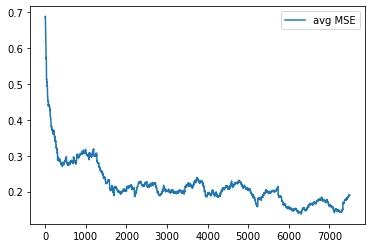

In [ ]:
plt.plot(running_mean(losses,window=500),label='avg MSE')
plt.legend()

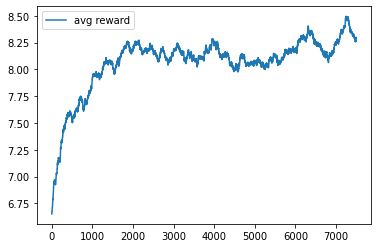

In [ ]:
plt.plot(running_mean(rewards, window=500), label="avg reward")
plt.legend()

In [ ]:
rewardsacc=[]
for _ in range (0,8000):
  state=torch.Tensor(one_hot_encode(np.random.randint(0,n_arms),dim=10))
  preds=model(state)
  action_probs=softmax(preds.data.numpy().copy())
  arm=np.random.choice(n_arms,p=action_probs)
  reward=env.choose_arm(arm)
  rewardsacc.append(reward)

rewardsarr=np.array(rewardsacc)

In [ ]:
def Average(lst):
    return sum(lst) / len(lst)

In [ ]:
avg=Average(rewardsacc)
print(avg)

5.551875


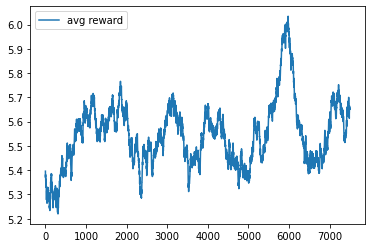

In [ ]:
plt.plot(running_mean(rewardsarr, window=500), label="avg reward")
plt.legend()

In [ ]:
state = torch.Tensor(one_hot_encode(5, dim=10))
preds = model(state)
print(preds)

tensor([ 5.2588,  0.0000,  3.1236,  0.0000,  7.9822,  0.0000,  0.8561, 10.2386,
         3.8589,  9.3666], grad_fn=<ReluBackward0>)
